## Data BPS

In [2]:
# Import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Memuat dataset
file_path = 'datasetbps.csv'  # Gunakan nama file di folder yang sama
data = pd.read_csv(file_path)

# Menampilkan informasi awal dataset
print(data.head())  # 5 data pertama
print(data.info())  # Info dataset
print(data.describe())  # Statistik deskriptif

      38 Provinsi                                         Unnamed: 1  \
0             NaN  Luas Panen, Produksi, dan Produktivitas Padi M...   
1             NaN                                    Luas Panen (ha)   
2             NaN                                               2024   
3            ACEH                                          301081.97   
4  SUMATERA UTARA                                          419089.12   

              Unnamed: 2      Unnamed: 3  
0                    NaN             NaN  
1  Produktivitas (ku/ha)  Produksi (ton)  
2                   2024            2024  
3                  54.58      1643355.07  
4                   51.4      2154117.08  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   38 Provinsi  39 non-null     object
 1   Unnamed: 1   42 non-null     object
 2   Unnamed: 2   41 non-null     object
 3

## Preprocessing Data

In [7]:
# Mengatur ulang header dan membersihkan data
data_cleaned = data.rename(columns={
    "38 Provinsi": "Provinsi",
    "Unnamed: 1": "Luas Panen (ha)",
    "Unnamed: 2": "Produktivitas (ku/ha)",
    "Unnamed: 3": "Produksi (ton)"
})

In [9]:
# Menghapus baris yang tidak relevan
data_cleaned = data_cleaned.dropna(subset=["Provinsi"]).reset_index(drop=True)
data_cleaned = data_cleaned[~data_cleaned["Provinsi"].str.contains("Luas Panen|Produktivitas|Produksi", na=False)]

In [11]:
# Mengkonversi data numerik
for col in ["Luas Panen (ha)", "Produktivitas (ku/ha)", "Produksi (ton)"]:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

In [13]:
# Menampilkan data bersih
print(data_cleaned.head())

         Provinsi  Luas Panen (ha)  Produktivitas (ku/ha)  Produksi (ton)
0            ACEH        301081.97                  54.58      1643355.07
1  SUMATERA UTARA        419089.12                  51.40      2154117.08
2  SUMATERA BARAT        296215.93                  45.64      1352048.77
3            RIAU         57003.35                  39.62       225836.50
4           JAMBI         64119.24                  45.44       291367.31


## Split Data

In [16]:
# Fitur dan target
X = data_cleaned[["Luas Panen (ha)", "Produktivitas (ku/ha)"]]
y = data_cleaned["Produksi (ton)"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Random Forest

In [19]:
# Melatih model Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

# Evaluasi model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Squared Error (MSE): 386544002892.04034
R-squared (R²): 0.8325109461662874


## Feature Importance

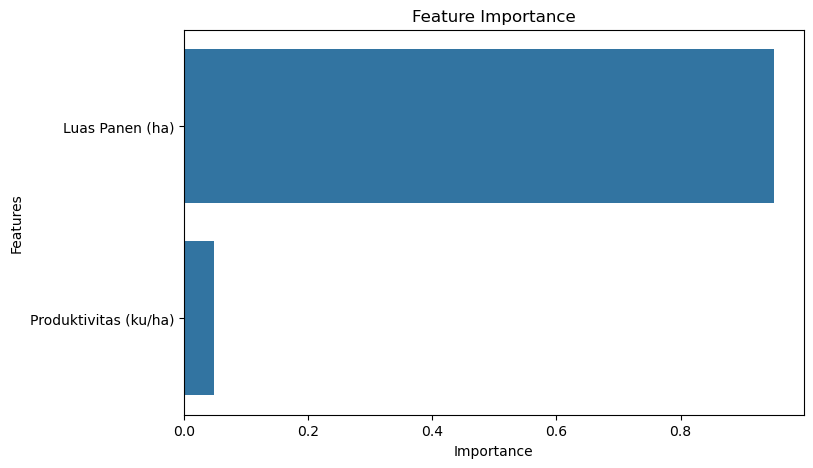

In [22]:
# Mengekstrak pentingnya fitur
feature_importances = model.feature_importances_

# Visualisasi pentingnya fitur
features = X.columns
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

## Hyperparameter Tuning

In [25]:
# Parameter yang akan di-tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [27]:
# Melatih model dengan GridSearchCV
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluasi model terbaik
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [29]:
print(f"Tuned Model MSE: {mse_best}")
print(f"Tuned Model R²: {r2_best}")

Tuned Model MSE: 403289783504.9614
Tuned Model R²: 0.8252550194682126


## Residual Analysis

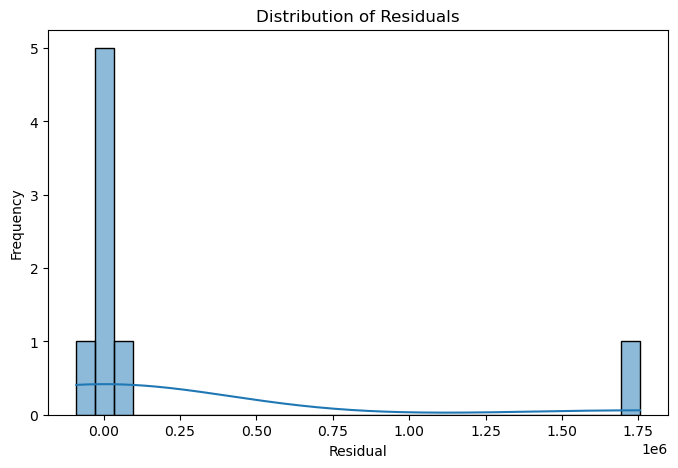

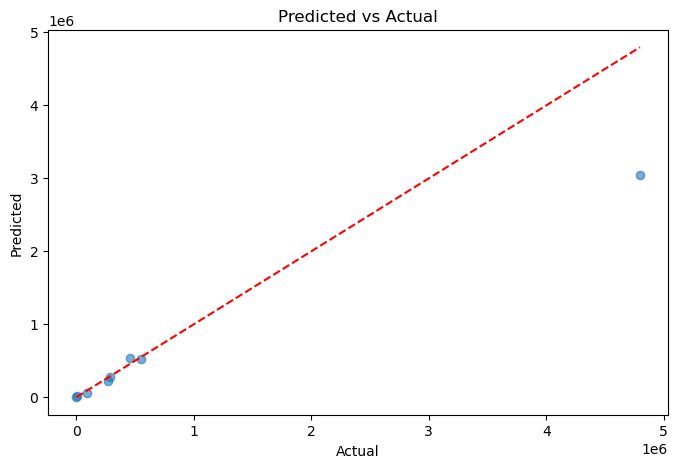

In [32]:
# Hitung residuals
residuals = y_test - y_pred

# Visualisasi residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Scatter plot prediksi vs nilai aktual
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

## Model Alternatif: Linear Regression

In [35]:
# Model Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Prediksi
y_pred_lr = linear_model.predict(X_test)

# Evaluasi Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R²: {r2_lr}")

Linear Regression MSE: 19047032107.170174
Linear Regression R²: 0.9917469437836259


##  Cross-Validation

In [38]:
# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("Cross-Validation R² Scores:", cv_scores)
print("Mean R²:", cv_scores.mean())

Cross-Validation R² Scores: [ 0.62774108  0.59148201 -3.39669187  0.83118643  0.11329402]
Mean R²: -0.24659766395468335
